# bibliotecas utilizadas

In [18]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.integrate import simps
from scipy.signal import gaussian

from core.evolution import imaginary
from core.empirical import in_segregation

au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## função que gera o perfil de concentração

In [19]:
def concentration(x0, R, ml):
    nsl = 6 * ml # number of surrounding layers (each side)
    tl = ml + 2 * nsl  # total layers
    # bulk before well
    x = [0] * nsl
    # well
    for n in range(1, ml+1):
        x.append(in_segregation(x0, R, n))
    # barrier after well
    for n in range(1, nsl+1):
        x.append(in_segregation(x0, R, n+ml, ml))
    return np.arange(1, len(x)+1), np.array(x)

## parâmetros buscados

In [33]:
x0     = 0.16 # intended indium concentration
R      = 0.85 # segregation parameter
N      = 512 # number of grid points
offset = (0.7, 0.3)

# number of layers
ml_grid = [6, 10, 14, 18, 22]

# for ml in ml_grid:
#     layers, in_x = concentration(x0, R, ml)
#     plt.scatter(layers, in_x, label="Monolayers: %d" % ml)

# plt.xlabel('$x_0$ (In concentration)')
# plt.xlabel('z (\AA)')
# plt.legend()
# plt.plot()

## parâmetros de acordo com Martini

In [31]:
a0   = np.vectorize(lambda x:  6.08 *x+(1-x)*  5.650)
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

me   = np.vectorize(lambda x: 0.067*(1-0.426*x))
mhhz = np.vectorize(lambda x: 0.34 *(1+0.117*x))

## cálculo de acordo com o número de monolayers

In [34]:
PL_nosso = []
infos_e = []
infos_h = []

for ml in ml_grid:
    layers, in_x = concentration(x0, R, ml)

    def concentration_z(z):
        position = 0.0
        for x, a in zip(in_x, a0(in_x)):
            position += a/2.0
            if z < position:
                return x
        return in_x[0]

    z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
    in_x_z = np.vectorize(concentration_z)(z)
    gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)

    _a   = a(in_x_z)
    _b   = b(in_x_z)
    _c11 = c11(in_x_z)
    _c12 = c12(in_x_z)
    _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)

    gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
    gap_c      = offset[0] * gap_strain
    gap_v      = offset[1] * gap_strain

    z_au    = z/au2ang # angstrom to au
    v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
    v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au
    
    # imaginary evolution
    #electron   = imaginary(z_au,v_e_au,np.min(me(in_x_z)))
    #heavy_hole = imaginary(z_au,v_hh_au,np.min(mhhz(in_x_z)))
    
    electron   = imaginary(z_au,v_e_au ,  me(in_x_z))
    infos_e.append(electron)
    heavy_hole = imaginary(z_au,v_hh_au, mhhz(in_x_z))
    infos_h.append(heavy_hole)
    
    Ee      = electron['eigenvalues'][0]* au2ev
    Ce      = electron['counters'][0]
    Pe      = electron['precisions'][0]
    Te      = electron['timers'][0]
    Se      = electron['squared_euclidean_dist'][0]
    Ee_es   = electron['eigenstates'][0]
    
    Ehh     = heavy_hole['eigenvalues'][0]* au2ev
    Chh     = heavy_hole['counters'][0]
    Phh     = heavy_hole['precisions'][0]
    Thh     = heavy_hole['timers'][0]
    Shh     = heavy_hole['squared_euclidean_dist'][0]
    Ehh_es  = heavy_hole['eigenstates'][0]
    
#     envelope  = Ee_es + Ehh_es
#     envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
#     z_med     = simps(envelope.conj()*z*envelope,z)
    
#     Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
#     Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
#     z_med  = simps(Ehh_es.conj()*z*Ee_es,z)

    Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
    z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
    
    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
    #gap_min = np.min(gap_strain)
    gap_min = gap_strain[idx]
    pl = gap_min+Ehh+Ee-7e-3
    PL_nosso.append(pl)
    
    print("ML={0:02d}, Ee={1:.8f}, Te={2:04.1f} s, Ehh={3:.8f}, Thh={4:04.1f} s, PL={5:.8f} eV".format(
        ml, Ee, Te, Ehh, Thh, pl))

ML=06, Ee=0.06595198, Te=13.8 s, Ehh=0.02548306, Thh=30.7 s, PL=1.50470272 eV
ML=10, Ee=0.07501578, Te=12.1 s, Ehh=0.02652217, Thh=21.2 s, PL=1.47126635 eV
ML=14, Ee=0.07138010, Te=09.8 s, Ehh=0.02379884, Thh=19.9 s, PL=1.44880232 eV
ML=18, Ee=0.06374104, Te=08.6 s, Ehh=0.02020645, Thh=19.0 s, PL=1.43048935 eV
ML=22, Ee=0.05535261, Te=09.2 s, Ehh=0.01680132, Thh=21.4 s, PL=1.41359130 eV


## PL de acordo com Martini e Experimental

In [6]:
PL_martini      = [1.50208315, 1.48793928, 1.4578344 , 1.4343612 , 1.41212442]
PL_experimental = [1.50498686, 1.49103033, 1.46214312, 1.43623456, 1.41525293]

## comparação

[]

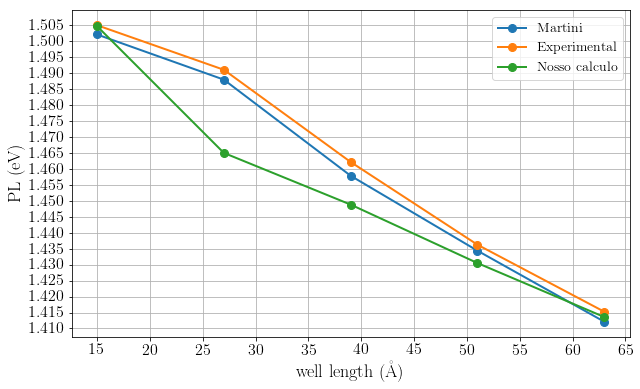

In [7]:
wl = [15, 27, 39, 51, 63]

fig = plt.figure()
ax  = fig.gca()

ax.set_xticks(np.arange(0, 70.00, 5.000))
ax.set_yticks(np.arange(0,  1.51, 0.005))
ax.set_xlabel('well length (\AA)')
ax.set_ylabel('PL (eV)')

ax.plot(wl, PL_martini     , '-o', label='Martini')
ax.plot(wl, PL_experimental, '-o', label='Experimental')
ax.plot(wl, PL_nosso       , '-o', label='Nosso calculo')

plt.legend()
plt.grid(True)
plt.plot()

In [17]:
for ml, electron, heavy_hole in zip(ml_grid, infos_e, infos_h):
    layers, in_x = concentration(x0, R, ml)

    def concentration_z(z):
        position = 0.0
        for x, a in zip(in_x, a0(in_x)):
            position += a/2.0
            if z < position:
                return x
        return in_x[0]

    z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
    in_x_z = np.vectorize(concentration_z)(z)
    gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)

    _a   = a(in_x_z)
    _b   = b(in_x_z)
    _c11 = c11(in_x_z)
    _c12 = c12(in_x_z)
    _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)

    gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
    gap_c      = offset[0] * gap_strain
    gap_v      = offset[1] * gap_strain

    z_au    = z/au2ang # angstrom to au
    v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
    v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au
    
    # imaginary evolution
    #electron   = imaginary(z_au,v_e_au,np.min(me(in_x_z)))
    #heavy_hole = imaginary(z_au,v_hh_au,np.min(mhhz(in_x_z)))
    
    Ee      = electron['eigenvalues'][0]* au2ev
    Ce      = electron['counters'][0]
    Pe      = electron['precisions'][0]
    Te      = electron['timers'][0]
    Se      = electron['squared_euclidean_dist'][0]
    Ee_es   = electron['eigenstates'][0]
    
    Ehh     = heavy_hole['eigenvalues'][0]* au2ev
    Chh     = heavy_hole['counters'][0]
    Phh     = heavy_hole['precisions'][0]
    Thh     = heavy_hole['timers'][0]
    Shh     = heavy_hole['squared_euclidean_dist'][0]
    Ehh_es  = heavy_hole['eigenstates'][0]
    
#     envelope  = Ee_es + Ehh_es
#     envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
#     z_med     = simps(envelope.conj()*z*envelope,z)
    
#     Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
#     Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
#     z_med  = simps(Ehh_es.conj()*z*Ee_es,z)/simps(Ehh_es.conj()*Ee_es,z)
    
    #Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
    Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
    z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
    
    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
    #gap_min = np.min(gap_strain)
    gap_min = gap_strain[idx]
    pl = gap_min+Ehh+Ee-7e-3
    PL_nosso.append(pl)
    
    print("ML={0:02d}, Ee={1:.8f}, Te={2:04.1f} s, Ehh={3:.8f}, Thh={4:04.1f} s, PL={5:.8f} eV".format(
        ml, Ee, Te, Ehh, Thh, pl))

ML=06, Ee=0.06595198, Te=14.9 s, Ehh=0.02548306, Thh=30.4 s, PL=1.50470272 eV
ML=10, Ee=0.07501578, Te=11.8 s, Ehh=0.02652217, Thh=20.9 s, PL=1.47126635 eV
ML=14, Ee=0.07138010, Te=09.5 s, Ehh=0.02379884, Thh=18.7 s, PL=1.44880232 eV
ML=18, Ee=0.06374104, Te=08.4 s, Ehh=0.02020645, Thh=18.7 s, PL=1.43048935 eV
ML=22, Ee=0.05535261, Te=08.1 s, Ehh=0.01680132, Thh=20.4 s, PL=1.41359130 eV


In [ ]:
[1.4888947  1.47994004 1.44912327 1.42298991 1.40406898]
[1.50208315 1.48793928 1.4578344  1.4343612  1.41212442]
[1.50498686 1.49103033 1.46214312 1.43623456 1.41525293]